In [139]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from joblib import dump, load

import shap
import lime
from sklearn.model_selection import train_test_split



In [140]:
file_path = '/Users/ameeshi/Desktop/fyp/data/FX_FanU_new.xlsx'
df = pd.read_excel(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

df_sg = df.drop(columns = ['CAD', 'KRONA', 'SGD', 'EURO', 'POUND', 'FRANC'])

df_sg['DATE'] = df_sg['DATE'].astype(str)
df_sg['DATE'] = df_sg['DATE'].str.split(' ').str[0]
df_sg.rename(columns={'DATE': 'Date'}, inplace=True)

df_sg.reset_index(drop = True)
# df_sg.to_csv("fx_filtered_sg.csv", index=False)

df_sg_train = df_sg[(df_sg['Date'] >= '2017-12-25') & (df_sg['Date'] <= '2019-12-31')]
df_sg_test = df_sg[(df_sg['Date'] >= '2020-01-01')]

In [141]:
df_sg_train

,Date,YEN
516,2017-12-25,113.385
517,2017-12-26,113.235
518,2017-12-27,113.300
519,2017-12-28,112.870
520,2017-12-29,112.650
...,...,...
1038,2019-12-25,109.340
1039,2019-12-26,109.640
1040,2019-12-27,109.585
1041,2019-12-30,108.985


In [142]:
# List of currencies
currencies = ['YEN']

# Dictionary to store cumulative accuracies
cumulative_accuracies = {}

In [143]:
# Function to create lag features
def create_lag_features(df, lag=5):
    df_new = pd.DataFrame(index=df.index)
    for i in range(lag+1):
        if i == 0:
            df_new[f'{currencies}_t'] = df[currencies].values
        else:
            df_new[f'{currencies}_t-{i}'] = df[currencies].shift(i).values
    df_new.dropna(inplace=True)
    return df_new

In [144]:
lag = 5  # You can adjust this
train_df_lagged = create_lag_features(df_sg_train, lag=lag)
test_df_lagged = create_lag_features(df_sg_test, lag=lag)

In [145]:
train_df_lagged

,['YEN']_t,['YEN']_t-1,['YEN']_t-2,['YEN']_t-3,['YEN']_t-4,['YEN']_t-5
521,112.650,112.650,112.870,113.300,113.235,113.385
522,112.145,112.650,112.650,112.870,113.300,113.235
523,112.395,112.145,112.650,112.650,112.870,113.300
524,112.775,112.395,112.145,112.650,112.650,112.870
525,113.230,112.775,112.395,112.145,112.650,112.650
...,...,...,...,...,...,...
1038,109.340,109.340,109.375,109.455,109.305,109.590
1039,109.640,109.340,109.340,109.375,109.455,109.305
1040,109.585,109.640,109.340,109.340,109.375,109.455
1041,108.985,109.585,109.640,109.340,109.340,109.375


In [146]:
# Separating features and labels
X_train_fx = train_df_lagged.iloc[:, 1:].values  # All lag features
y_train_fx = train_df_lagged.iloc[:, 0].values  # Current value to predict

X_test_fx = test_df_lagged.iloc[:, 1:].values
y_test_fx = test_df_lagged.iloc[:, 0].values


# dates = create_dataset(df_sg_train)



In [147]:
# Extract and store the 'Date' column
dates = df_sg_train['Date']
test_dates = df_sg_test['Date']

In [148]:
# to match the rates prediction columns with the dates
dates = dates[5:]


In [149]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust parameters
model.fit(X_train_fx, y_train_fx)

model_path = f'/Users/ameeshi/Desktop/fyp/joblibs/sg_model.joblib'  # Specify your path here
dump(model, model_path)

# Predicting for all dates in the dataset 
y_pred_train = model.predict(X_train_fx)

In [150]:
# Evaluating the model
train_error_mae = mean_absolute_error(y_train_fx, y_pred_train)
print(f"Train MAE: {train_error_mae}")

train_error_mse = mean_squared_error(y_train_fx, y_pred_train)
print(f"Train MSE: {train_error_mse}")

train_error_rmse = np.sqrt(train_error_mse)
print(f"Train RMSE: { train_error_rmse}")

train_r2 = r2_score(y_train_fx, y_pred_train)
print(f"Train r2 score: {train_r2}")


Train MAE: 0.12619693486590317
Train MSE: 0.027910588994254002
Train RMSE: 0.16706462520310517
Train r2 score: 0.9936450234183043


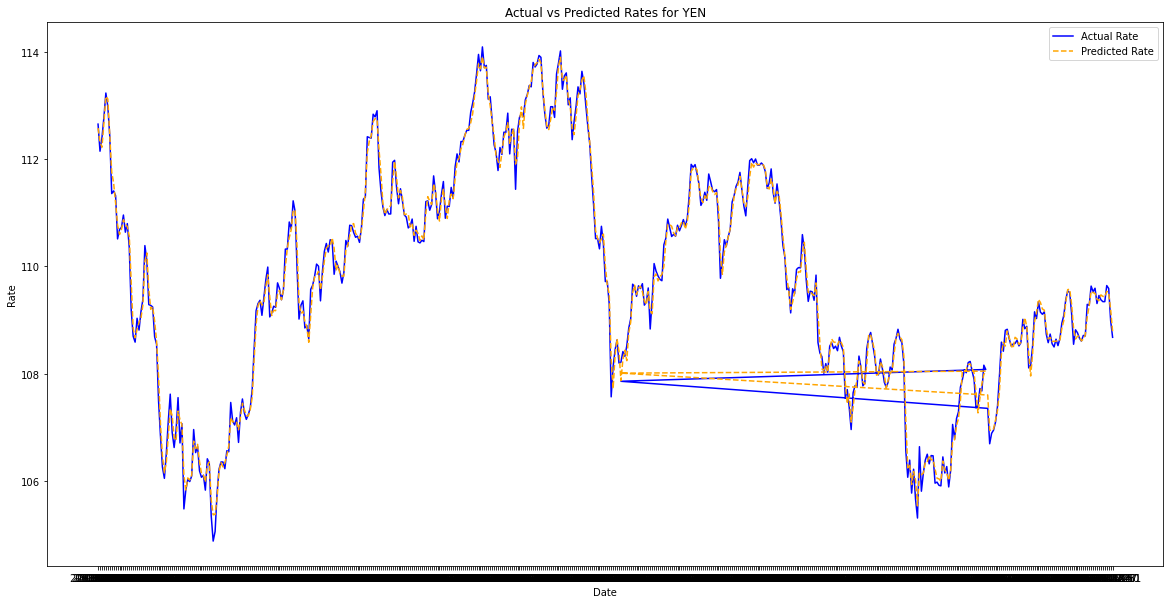

In [151]:
# for plot
plt.figure(figsize=(20,10))
plt.plot(dates, y_train_fx, label='Actual Rate', color='blue')
plt.plot(dates, y_pred_train, label='Predicted Rate', linestyle='--', color='orange')
plt.title(f'Actual vs Predicted Rates for YEN')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()
    

In [152]:
# for test dataset
y_pred_test = model.predict(X_test_fx)
test_error_mae = mean_absolute_error(y_test_fx, y_pred_test)
print(f"Test MAE: {test_error_mae}")

test_error_mse = mean_squared_error(y_test_fx, y_pred_test)
print(f"Test MSE: {test_error_mse}")

test_error_rmse = np.sqrt(test_error_mse)
print(f"Test RMSE: { test_error_rmse}")

test_r2 = r2_score(y_test_fx, y_pred_test)
print(f"Test r2 score: {test_r2}")

Test MAE: 0.6672324057450839
Test MSE: 0.8830580903995072
Test RMSE: 0.9397117060032333
Test r2 score: 0.9220839402780059


In [153]:
# adjusting test dates to match the prediction rate correctly
adjusted_test_dates = test_dates[lag:] 
adjusted_test_dates = adjusted_test_dates[:len(y_pred_test)]

In [154]:
actual_with_dates = {date: actual for date, actual in zip(adjusted_test_dates, y_test_fx)}

# Printing the first few items to verify
for date, actual in list(actual_with_dates.items())[:5]:
    print(f"Date: {date}, Actual: {actual}")

Date: 2020-01-08, Actual: 108.635
Date: 2020-01-09, Actual: 109.545
Date: 2020-01-10, Actual: 109.56
Date: 2020-01-13, Actual: 109.93
Date: 2020-01-14, Actual: 110.04


In [155]:
# Creating a dictionary to store predictions with their corresponding date
predictions_with_dates = {date: prediction for date, prediction in zip(adjusted_test_dates, y_pred_test)}

# Printing the first few items to verify
for date, prediction in list(predictions_with_dates.items())[:5]:
    print(f"Date: {date}, Prediction: {prediction}")

Date: 2020-01-08, Prediction: 108.62460000000004
Date: 2020-01-09, Prediction: 108.6164500000001
Date: 2020-01-10, Prediction: 109.83690000000013
Date: 2020-01-13, Prediction: 109.7886
Date: 2020-01-14, Prediction: 109.76805000000009


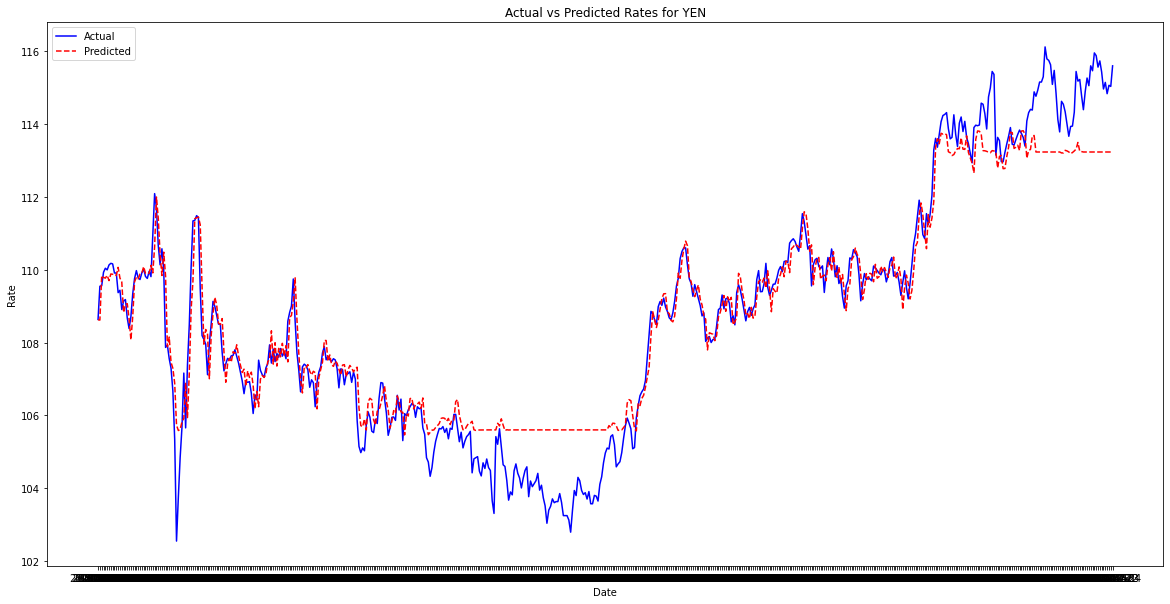

In [156]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(adjusted_test_dates, y_test_fx, label=f'Actual', linestyle='-', color='blue')
plt.plot(adjusted_test_dates, y_pred_test, label=f'Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for YEN')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [157]:
dtypes = {'RegionName': str, 'RegionCode': str}
file_path_oxford = '/Users/ameeshi/Desktop/fyp/OxCGRT_nat_latest.xlsx'  # Update this path
df_oxford = pd.read_excel(file_path_oxford, dtype=dtypes)



In [158]:
df_oxford.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
interested_country = ['Japan']
# Filter for Singapore
df_oxford_sg = df_oxford[df_oxford['CountryName'].isin(interested_country)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

df_oxford_sg['Date'] = df_oxford_sg['Date'].apply(convert_date)

columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]




# Drop unwanted columns
oxcg_filtered = df_oxford_sg.drop(columns=columns_to_drop)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [160]:
oxcg_filtered.head(3)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,ConfirmedCases,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay
93219,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
93220,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
93221,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0


In [161]:

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

In [162]:
oxcg_filtered.head(3)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,ConfirmedCases,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay
0,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,2.0,0.0,0.0,0.0,0.0
1,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,2.0,0.0,0.0,0.0,0.0
2,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,2.0,0.0,0.0,0.0,0.0


In [163]:
country = {'YEN': ['Japan', 'YEN']}

In [164]:
oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

In [165]:
# making a new dataframe for predicted rates and the dates for merging 
rates_df = pd.DataFrame(list(predictions_with_dates.items()), columns = ['Date', 'PredRate'])

In [166]:
actualrate_df = pd.DataFrame(list(actual_with_dates.items()), columns = ['Date', 'ActualRate'])

In [167]:
rates_df.head(3)


,Date,PredRate
0,2020-01-08,108.62460
1,2020-01-09,108.61645
2,2020-01-10,109.83690


In [168]:
actualrate_df.head(3)

,Date,ActualRate
0,2020-01-08,108.635
1,2020-01-09,109.545
2,2020-01-10,109.560


In [169]:
merged_df = pd.merge(oxcg_filtered, rates_df, on='Date', how='inner')

In [170]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate
0,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,108.62460
1,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,108.61645
2,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.83690
3,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.78860
4,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.76805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,1.0,...,1.0,5.0,1.0,NaN,47.22,54.57,48.07,100.0,87698.0,113.23335
553,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,1.0,...,1.0,5.0,1.0,NaN,47.22,54.57,48.07,100.0,51909.0,113.23335
554,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,1.0,...,1.0,5.0,1.0,NaN,47.22,54.57,48.07,100.0,69617.0,113.23335
555,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,1.0,...,1.0,5.0,1.0,NaN,47.22,54.57,48.07,100.0,80351.0,113.23335


In [171]:
merged_df = pd.merge(merged_df, actualrate_df, on = 'Date', how = 'inner')

In [172]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,108.62460,108.635
1,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,108.61645,109.545
2,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.83690,109.560
3,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.78860,109.930
4,Japan,JPN,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,2.78,1.56,1.79,0.0,0.0,109.76805,110.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,87698.0,113.23335,115.145
553,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,51909.0,113.23335,114.835
554,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,69617.0,113.23335,115.065
555,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,80351.0,113.23335,115.035


In [173]:
# train data
oxcg_filtered_train = merged_df[(merged_df['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

# test data
oxcg_filtered_test = merged_df[(merged_df['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [174]:
oxcg_filtered_test

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,Japan,JPN,NaN,NaN,NAT_TOTAL,2021-01-01,1.0,1.0,1.0,0.0,...,0.0,3.0,NaN,48.15,57.81,51.79,100.0,3256.0,105.59940,103.245
1,Japan,JPN,NaN,NaN,NAT_TOTAL,2021-01-04,1.0,1.0,1.0,0.0,...,0.0,3.0,NaN,48.15,57.81,51.79,100.0,3343.0,105.59940,103.125
2,Japan,JPN,NaN,NaN,NAT_TOTAL,2021-01-05,1.0,1.0,1.0,1.0,...,0.0,3.0,NaN,49.54,58.59,52.68,100.0,4949.0,105.59940,102.790
3,Japan,JPN,NaN,NaN,NAT_TOTAL,2021-01-06,1.0,1.0,1.0,1.0,...,0.0,3.0,NaN,49.54,58.59,52.68,100.0,6049.0,105.59940,103.390
4,Japan,JPN,NaN,NaN,NAT_TOTAL,2021-01-07,1.0,1.0,1.0,1.0,...,0.0,3.0,NaN,49.54,58.59,52.68,100.0,7642.0,105.59940,103.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,87698.0,113.23335,115.145
296,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,51909.0,113.23335,114.835
297,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,69617.0,113.23335,115.065
298,Japan,JPN,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,1.0,...,5.0,1.0,NaN,47.22,54.57,48.07,100.0,80351.0,113.23335,115.035


In [175]:
oxcg_test_dates = oxcg_filtered_test['Date']

In [176]:
oxcg_filtered_test.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1M_School closing', 'C2M_Workplace closing',
       'C3M_Cancel public events', 'C4M_Restrictions on gatherings',
       'C5M_Close public transport', 'C6M_Stay at home requirements',
       'C7M_Restrictions on internal movement',
       'C8EV_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6M_Facial Coverings', 'H7_Vaccination policy',
       'H8M_Protection of elderly people', 'M1_Wildcard',
       'StringencyIndex_Average_ForDisplay',
       'GovernmentResponseIndex_Average_ForDisplay',
       'ContainmentHealthIndex_Average_ForDisplay',
       'EconomicSupportIndex_ForDisplay', 'DailyChange', 'PredRate',
       'ActualRate

In [177]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features_to_select = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people', ]

# fx_rate = predictions_with_dates.get("Prediction")

In [178]:
X_train_oxcg = oxcg_filtered_train[features_to_select]
y_train_oxcg = oxcg_filtered_train['PredRate']

X_test_oxcg = oxcg_filtered_test[features_to_select]
y_test_oxcg = oxcg_filtered_test["PredRate"]
y_test_act = oxcg_filtered_test['ActualRate']

In [179]:
oxcg_model = RandomForestRegressor(n_estimators=100, random_state=42)
oxcg_model.fit(X_train_oxcg, y_train_oxcg)

RandomForestRegressor(random_state=42)

In [180]:
# predicting revised rate 
y_pred = oxcg_model.predict(X_test_oxcg)


In [181]:
mae = mean_absolute_error(y_test_act, y_test_oxcg)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test_act, y_test_oxcg)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f" RMSE: { rmse}")

r2 = r2_score(y_test_act, y_test_oxcg)
print(f"r2 score: {r2}")

Mean Absolute Error: 0.6892905000000097
Mean Squared Error: 0.9628535534583483
 RMSE: 0.9812510145005447
r2 score: 0.9120056058496571


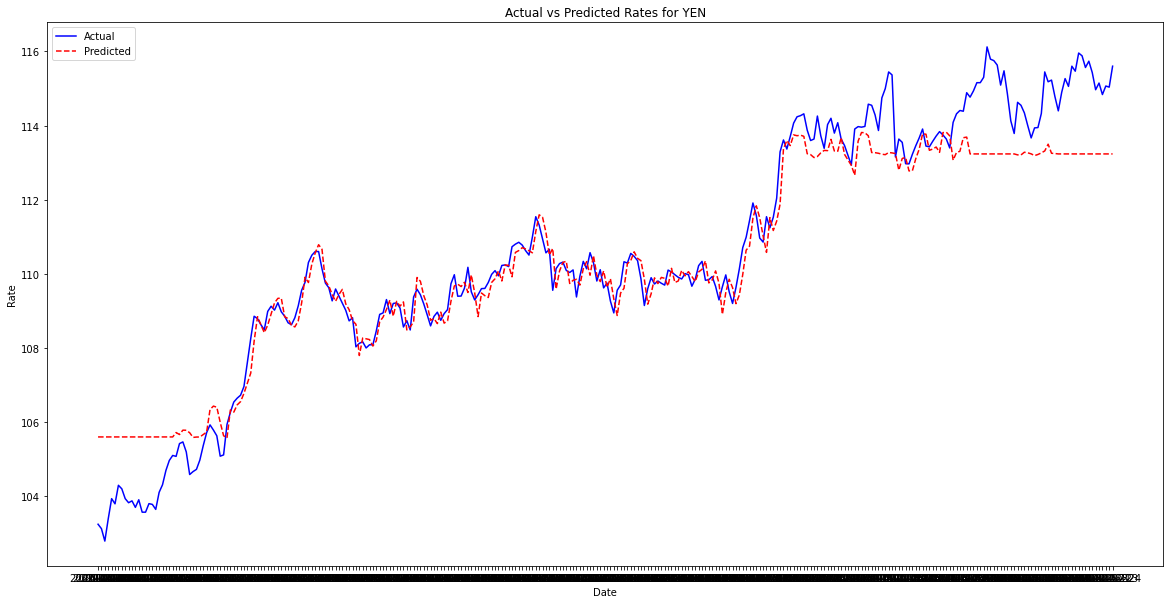

In [182]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(oxcg_test_dates, y_test_act, label=f'Actual', linestyle='-', color='blue')
plt.plot(oxcg_test_dates, y_test_oxcg, label=f'Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for YEN')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [183]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(oxcg_model, X_train_oxcg)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_oxcg)

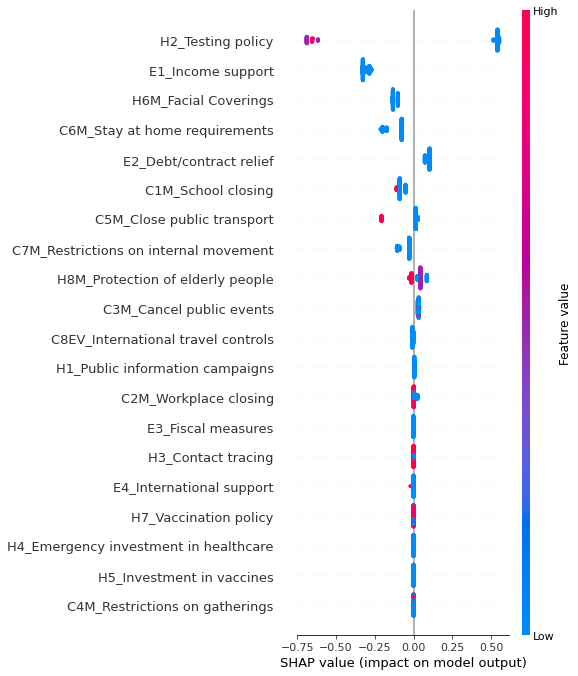

In [184]:
shap.summary_plot(shap_values, X_test_oxcg)

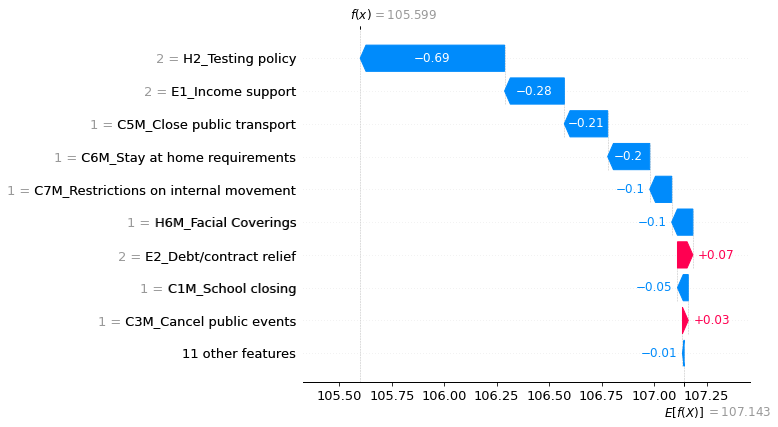

In [185]:
shap.plots.waterfall(shap_values[0])

In [186]:
from lime import lime_tabular

In [187]:
X_train_oxcg_df = pd.DataFrame(X_train_oxcg, columns=features_to_select)

# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_oxcg_df.values,
    feature_names=features_to_select,
    mode='regression'
)

In [188]:
instance_idx = 0  # For example, explaining the first instance in the test set
instance = X_test_oxcg.iloc[instance_idx].values

# Generate the LIME explanation
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=oxcg_model.predict
)

# Display the explanation
# For Jupyter notebooks:
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
